In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
#look at the columns in the classes
inspector = inspect(engine)
columns_meas = inspector.get_columns('measurement')
for column in columns_meas:
    print(column["name"],column["type"])
print("_______")
columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
_______
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

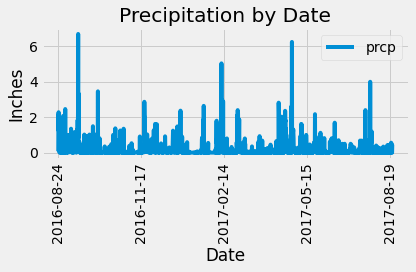

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
datefirst = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#convert string to datetime format
date = dt.datetime.strptime(datefirst[0], '%Y-%m-%d')
#get date 12 months previously
back = pd.DateOffset(months=12)
date = date - back

# Perform a query to retrieve the date and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= str(date)).order_by(Measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results,columns=['date','prcp'])
df.set_index('date',inplace=True,)

# Sort the dataframe by date
df = df.sort_values('date')

# Drop the NAN values from the dataframe
df = df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(title="Precipitation by Date", rot=90)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
station_count2 = session.query(Measurement.station).group_by(Measurement.station).count()
print(station_count)
print(station_count2)

9
9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_desc = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
for row in stations_desc:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = stations_desc[0][0]
stations_temp_low = session.query(func.min(Measurement.tobs)).filter_by(station = station_id).all()
stations_temp_high = session.query(func.max(Measurement.tobs)).filter_by(station = station_id).all()
stations_temp_avg = session.query(func.avg(Measurement.tobs)).filter_by(station = station_id).all()
print(f"Lowest Temperature at station {station_id}: {stations_temp_low[0][0]}")
print(f"Highest Temperature at station {station_id}: {stations_temp_high[0][0]}")
print(f"Average Temperature at station {station_id}: {round(stations_temp_avg[0][0],1)}")

Lowest Temperature at station USC00519281: 54.0
Highest Temperature at station USC00519281: 85.0
Average Temperature at station USC00519281: 71.7


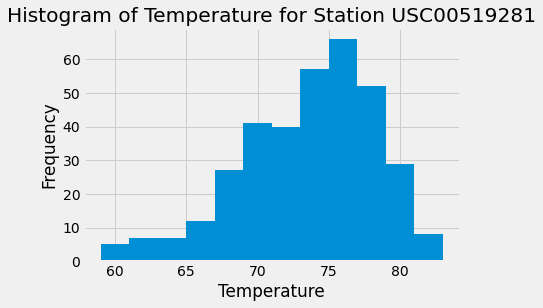

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date >= str(date)).filter(Measurement.station == station_id).order_by(Measurement.date).all()
df_temp = pd.DataFrame(temp,columns=['date','temp'])
df_temp.set_index('date',inplace=True,)
plt.hist(df_temp["temp"], bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Histogram of Temperature for Station USC00519281")
plt.show()

#close session
session.close()

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
